# BLU09 - Part 2 - NLP feature engineering and feature unions

We have already learned how to use words as input for ML models and how to extract their linguistic properties (which we could also use as model inputs). Here we'll look at other simple features that you can extract from text.

This part will also introduce you to feature unions, which are basically parallel pipelines. The pipelines we used in specialization 1 were applying operations to the data sequentially. Feature unions can apply operations in parallel, e.g. starting from a text, we can vectorize it and also extract word counts, text length, etc., then input all the extracted features into a classifier.

We are going to use a very well known Kaggle dataset for spam detection - [Kaggle Spam Collection](https://www.kaggle.com/uciml/sms-spam-collection-dataset) and determine if an SMS is 'spam' or 'not spam' (also known as ham). 

![ham_or_spam](./media/ham_spam.jpg)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score
import nltk
import spacy

## 1. Spam and Ham

Let's load the data.

In [2]:
df = pd.read_csv('data/spam.csv', encoding='latin1')
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df = df.rename(columns={"v1":"label", "v2":"message"})
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


You could think that it should be easy to detect the spam text, since it is quite clear to the human eye. I don't know about you, but I'm always suspicious of free stuff. There ain't no such thing as a free lunch.

But by now you should also know that what seems obvious to us humans is sometimes not as easy to detect with a model. So, what kind of features could you use for this? The most obvious ones are the words themselves, which you already know how to deal with - using the CountVectorizer or the TfIdfVectorizer (or SpaCy, but we'll keep it simple here). We're going to create a baseline model based on the text vectorization and later on try to engineer new features to improves this baseline.

### 1.1 Baseline

To start with, let's look at the target class distribution.

In [3]:
df.label.value_counts(normalize=True)

label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64

So, if we were to create a dumb classifier which always predicts "ham", we would get an accuracy of 86.6% for this dataset.

Let's get our baseline with the Bag-of-Words approach. We are going to set up a pipeline with a TfidfVectorizer followed by a RandomForestClassifier, a powerful machine learning classifier that fits very well in this problem.

In [4]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=41)

text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                   ('classifier', RandomForestClassifier(random_state = 41))])

text_clf.fit(train_data['message'], train_data['label'])

predicted = text_clf.predict(test_data['message'])
print(f'accuracy: {accuracy_score(test_data['label'], predicted)}')
print(f'recall: {recall_score(test_data['label'], predicted, pos_label='spam')}')

accuracy: 0.9704035874439462
recall: 0.7898089171974523


Powerful words, no?

Our next step is to engineer new features. 

## 2. Adding extra features

Besides this Bag-of-Words vectorization, let's see what other signals can we retrieve from the text to feed into the classifier. We could measure the length of the messages in characters for example. We'll add it as a feature to our dataframe.

In [5]:
df['length'] = df['message'].map(len)
df.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Is this feature useful?

Since this is only one numerical feature, we can simply plot its distribution in our data. Here is the message length distribution for "Spam" and "Ham":

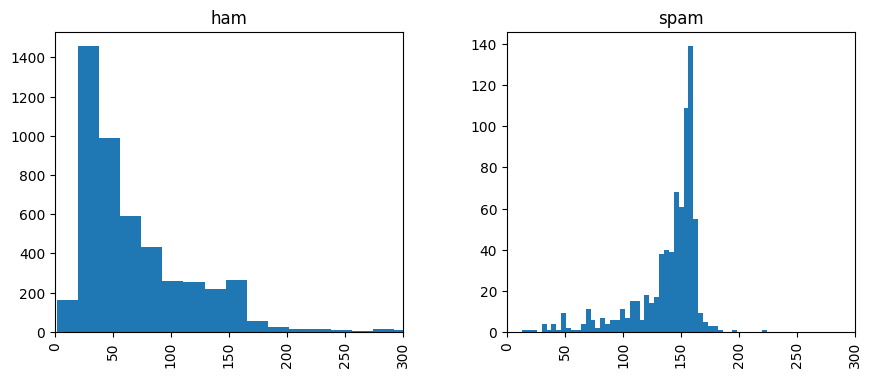

In [6]:
ax_list = df.hist(column='length', by='label', bins=50, figsize=(10,4))
ax_list[0].set_xlim((0,300))
ax_list[1].set_xlim((0,300));

Seems like the spam messages tend to be longer. This feature could be helpful in the classifier. Let's see how to include it in the pipeline alongside the BoW processing.

### 2.1 Selector transformers

In simple pipelines that we have used so far, the same processing was applied to all the data fed into the pipeline. For our heterogeneous data where we have a text column and a numerical column, this doesn't quite work.

So what if we want to have a pipeline using several different features from several different columns? We can't apply the same pipeline steps to everything, right? The first step is to create a separate pipeline for every feature. We can do this by including a **selector transformer** into the pipeline which selects the column to use.

Here we define two such transformers: `TextSelector` for text columns and `NumberSelector` for numerical columns. They are basically the same, but we will use one to select text features and the other for numerical features.

In [7]:
class Selector(TransformerMixin, BaseEstimator):
    """
    Transformer to select a column from a dataframe
    on which to perform additional transformations.
    """ 
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    

class TextSelector(Selector):
    """
    Transformer to select a single text column from a dataframe
    on which to perform additional transformations.
    """
    def transform(self, X):
        return X[self.key]


class NumberSelector(Selector):
    """
    Transformer to select a single numerical column from a dataframe
    on which to perform additional transformations.
    """
    def transform(self, X):
        return X[[self.key]]

Now we define pipelines tailored to each case, for the text column ('message') and for the numerical column ('length').  

In [8]:
text = Pipeline([
                ('selector', TextSelector("message")),
                ('tfidf', TfidfVectorizer())
            ])

length =  Pipeline([
                ('selector', NumberSelector("length")),
                ('standard', StandardScaler())
            ])

Notice that we used the `StandardScaler` for the numerical feature. The use of this scaler (scales the feature to zero mean and unit variance) is because we don't want to have different feature scales in our classifier. Most of classification algorithms expect the features to be on the same scale. 

You might be wondering now:

> *How does this solve my problem... now I have two pipelines and although I can feed in my whole dataset they are separate pipelines... does this help at all?*

In fact, if you were to run them separately this would not be that helpful, since you would have to add the classifier at the end of each. It seems like we are missing a piece, a way to combine steps in parallel and not in sequence. This is where feature unions come in!

### 2.2 Feature unions

While pipelines define a cascaded workflow, feature unions allow you to parallelize your workflows and have several transformations applied in parallel in the same pipeline. The image below presents a simple sequential pipeline:

<img src="./media/pipeline.png" width="300">

And this is a parallel pipeline called a feature union:

<img src="./media/unions.png" width="70%">

The latter is quite simple to define in scikit-learn as follows. We will join the previously defined `text` and `length` pipelines into one feature union. The feature union will preprocess both features to prepare them for the classification step.

In [9]:
feats = FeatureUnion([('text', text), 
                      ('length', length)])

Now you can use the feature union inside the final pipeline which will also include the classification step.

<img src="./media/pipelines_dawg.png" width="400">

In [10]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=41)

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 41)),
])

pipeline.fit(train_data, train_data.label)

preds = pipeline.predict(test_data)
print(f'accuracy: {accuracy_score(test_data['label'], preds)}')
print(f'recall: {recall_score(test_data['label'], preds, pos_label='spam')}')

accuracy: 0.9713004484304932
recall: 0.7961783439490446


The message length feature resulted in a tiny improvement of the already high baseline on both accuracy and recall. Let's compute more numerical features from the text and see if we can improve the classification score even more.

### 2.3 More features

What other features can you think of? We could continue by calculating the word count.

In [11]:
df['words'] = df['message'].str.split().map(len)

Remember BLU07? Remember stopwords?  

<img src="./media/stopwords.png" width="300">

Let's count only words that are not stopwords, since those are usually less relevant.

In case the cell below returns an error, make sure to run the command `nltk.download('stopwords')`.

In [12]:
stop_words = nltk.corpus.stopwords.words('english')
df['words_not_stopword'] = df['message'].apply(lambda x: len([t for t in x.split() if t not in stop_words]))

In the same way, we can count other text characteristics, like the number of commas or words that are uppercased or capitalized.

In [13]:
df['commas'] = df['message'].str.count(',')
df['upper'] = df['message'].map(lambda x: map(str.isupper, x)).map(sum)
df['capitalized'] = df['message'].map(lambda x: map(str.istitle, x)).map(sum)

We can also calculate the average word length.

In [14]:
df['avg_word_length'] = df['message'].apply(lambda x: np.mean([len(t) for t in x.split() if t not in stop_words])
                                            if len([len(t) for t in x.split(' ') if t not in stop_words]) > 0 else 0)

Let's take a look at our final dataframe with all the features we added:

In [15]:
df.head()

,label,message,length,words,words_not_stopword,commas,upper,capitalized,avg_word_length
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,16,1,3,3,4.750000
1,ham,Ok lar... Joking wif u oni...,29,6,6,0,2,2,4.000000
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,23,0,10,10,5.173913
3,ham,U dun say so early hor... U c already then say...,49,11,9,0,2,2,3.666667
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,8,1,2,2,4.250000


Now we will use the feature unions to process everything. We will create a preprocessing pipeline for every feature, then join them into a feature union. Easy, right? 

In [16]:
words =  Pipeline([
                ('selector', NumberSelector(key='words')),
                ('standard', StandardScaler())
            ])
words_not_stopword =  Pipeline([
                ('selector', NumberSelector(key='words_not_stopword')),
                ('standard', StandardScaler())
            ])
avg_word_length =  Pipeline([
                ('selector', NumberSelector(key='avg_word_length')),
                ('standard', StandardScaler())
            ])
commas =  Pipeline([
                ('selector', NumberSelector(key='commas')),
                ('standard', StandardScaler()),
            ])
upper =  Pipeline([
                ('selector', NumberSelector(key='upper')),
                ('standard', StandardScaler()),
            ])
capitalized =  Pipeline([
                ('selector', NumberSelector(key='capitalized')),
                ('standard', StandardScaler()),
            ])

feats = FeatureUnion([('text', text), 
                      ('length', length),
                      ('words', words),
                      ('words_not_stopword', words_not_stopword),
                      ('avg_word_length', avg_word_length),
                      ('commas', commas),
                     ('upper', upper),
                     ('capitalized', capitalized)])

Now we can add a classifier to finalize the pipeline and finally classify the data.

*Drumroll, please.*

In [17]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=41)

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 41)),
])

pipeline.fit(train_data, train_data.label)

preds = pipeline.predict(test_data)

print(f'accuracy: {accuracy_score(test_data['label'], preds)}')
print(f'recall: {recall_score(test_data['label'], preds, pos_label='spam')}')

accuracy: 0.9721973094170404
recall: 0.8089171974522293


<img src="./media/sad.png" width="300">

Well, that was a bit underwhelming... Another small improvement, but not a breaktrough. At least we cracked the 80% threshold on recall.

But don't despair, with all the tools from this specialization you are already perfectly equipped to find more exciting new features and maybe improve the score some more. You could also try to integrate dimensionality reduction techniques into the pipeline.

## 3. Final remarks and further reading

And we are at the end of the NLP specialization. It saddens me, but it is time to say goodbye. 

<img src="./media/so_long.jpg" width="400">

In this specialization you learned:

* how to process text.
* how to create features from text.
* methods to analyze feature importance.
* methods to perform feature reduction.
* how to design pipelines and combine different features inside them.

You are now armed with several tools to perform text classification and information extraction. Don't forget to review all of this for the NLP hackathon, and to do your best in the exercises.

### 3.1 Further reading
The most recent approaches to text processing are based on deep learning. Deep learning methods are out of the scope of this course, but it is important that the reader is aware of the potential (and problems) of such methods compared to classical machine learning algorithms. In particular, we suggest to read about these two libraries:

* [StarSpace](https://github.com/facebookresearch/StarSpace)
* [Vowpal Wabbit classifier](https://github.com/JohnLangford/vowpal_wabbit/wiki)

More about pipelines:
* how to use a pipeline in [cross-validation](https://www.kaggle.com/code/baghern/a-deep-dive-into-sklearn-pipelines#Cross-Validation-To-Find-The-Best-Pipeline).
* a [pipeline example](http://michelleful.github.io/code-blog/2015/06/20/pipelines/) to classify street names.
* [Sklearn examples](https://scikit-learn.org/stable/auto_examples/compose/index.html) illustrating the use of column transformers.